<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/gene_expression_master_kevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from copy import deepcopy

In [129]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [111]:
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index
genes_hum_index = [x for x in genes.index if x not in genes_bac_index]

In [112]:
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
express_norm_samp = pd.concat([expression_norm, samples], axis=1)

Regression model based on (plate-wise bacteria-based) normalized data

In [105]:
# expression = b0 + b1 * sex + b2 * region + b3 * lab
#train one model per gene. 

samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:22<00:00, 554.13it/s]


In [106]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = np.array(genes.loc[top100genes].loc[:, 'chrom'].values)
op_genes = np.array(genes.loc[top100genes].loc[:, 'sym'].values)
print(op_chrom)

['Y' 'Y' 'Y' 'Y' 'Y' 'X' 'X' 'Y' 'Y' 'Y' 'X' '10ptp*' '6' '5' 'Y' '19'
 '11hbg' 'X Y' '17' '11' '2' '13' '16hba1' '22' '16' '4' '10' '9' '7' '1'
 '3' '9' '3' nan '16' '3' '4' '11' nan '10' 'X Y' '22' '10' '2' '45ac*'
 '20' '7' '3' '2' '17' 'X' '7' 'X Y' '5' '3' '14' '3' '1' '21' nan '21'
 '13' '2' '7' '6' '1' '19' '5' '6' '11' '13' '1' '17' '3' '2' '5' '18'
 '10' '6' '14' '6' '12' '11' '16' '16' '7' '9' '3' '1' '3' '21' '3' '5'
 '2' '11' '16nomo1' '16' '2' '5' '9']


In [107]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

10
13
14
16


In [133]:
# expression = b0 + b1 * sex + b2 * region + b3 * labchip
#train one model per gene. 

samples_tmp = deepcopy(samples)
samples_tmp['labchip'] = samples_tmp['lab'].astype(str) + '.' + samples_tmp['chip.version'].astype(str)
samples_tmp = samples_tmp.drop(columns= ["patient", "lab", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "labchip_Michigan.v2"]);

coef_gene = []
for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:59<00:00, 212.40it/s]


In [134]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = np.array(genes.loc[top100genes].loc[:, 'chrom'].values)
op_genes = np.array(genes.loc[top100genes].loc[:, 'sym'].values)
print(op_chrom)

['Y' 'Y' 'Y' 'Y' 'Y' 'X' 'X' 'Y' 'Y' 'Y' 'X' '10ptp*' '6' '5' 'Y' '19'
 '11hbg' 'X Y' '17' '11' '2' '13' '16hba1' '22' '16' '4' '10' '9' '7' '1'
 '3' '9' '3' nan '16' '3' '4' '11' nan '10' 'X Y' '22' '10' '2' '45ac*'
 '20' '7' '3' '2' '17' 'X' '7' 'X Y' '5' '3' '14' '3' '1' '21' nan '21'
 '13' '2' '7' '6' '1' '19' '5' '6' '11' '13' '1' '17' '3' '2' '5' '18'
 '10' '6' '14' '6' '12' '11' '16' '16' '7' '9' '3' '1' '3' '21' '3' '5'
 '2' '11' '16nomo1' '16' '2' '5' '9']


In [135]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

10
13
14
16


Regression model based on (plate-wise bacteria-based) normalized data, for each lab

In [140]:
# expression = b0 + b1 * sex + b2 * region
#train one model per gene. 

temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
coef_gene = []
samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:22<00:00, 559.87it/s]


In [141]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = genes.loc[top100genes].loc[:, 'chrom'].values
op_genes = genes.loc[top100genes].loc[:, 'sym'].values
print(np.array(op_chrom))
print(np.array(op_genes))
print([x[0] for x in sorted_coef_gene[:10]])

['Y' 'Y' 'X' 'Y' 'X' 'Y' '8' 'Y' '19' 'Y' '11hbg' nan '7' '16' 'Y' '1' nan
 '16' '22' '7' '2' 'X Y' '6' '19' '2' '9' '3' '22gg*' '20' '6' '19' '4'
 '1' 'X' '11' '6' '21' nan '1' '3' '17' '12' '1' '3' nan '5' 'X' '12' '21'
 'X' nan '7' '17' '19' '9' '4' '6' nan '12' 'X' '10' '4' '14' '6' '19' '3'
 '22' '4' 'X' '4' '17' '17' '14' '11' '19' '4' '14' '12' '19' '19' '7'
 '12' '4' '3' '19' '17' '13' '19' '15' '10ptp*' '3' '13' '12' '15' '11'
 nan '7' '15' '14' '5']
['RPS4Y1' 'DDX3Y' nan 'KDM5D' 'XIST' 'TTTY15' 'MOS' 'CYorf15B' 'LYL1'
 'USP9Y' nan nan 'CASP2' 'MYLPF' 'UTY' 'MYOC' nan 'KIAA0430' 'LGALS2'
 'IKZF1' 'IL18R1' 'CD99' 'FLOT1' 'GRIN2D' 'SIX3' 'NFX1' 'RAP2B' nan 'GDF5'
 'ZKSCAN3' 'CRX' 'BMP3' 'AK3L1' 'THOC2' 'LPXN' 'HIST1H3E' 'SH3BGR' nan
 'CDC2L2' 'SR140' 'MAPK7' 'APOF' 'FCN3' 'CASR' nan 'C9' 'IL13RA1'
 'SNRNP35' 'DOPEY2' 'AMELX' nan 'HOXA9' 'EVPL' 'KIR3DL3' 'MLANA' 'NPY2R'
 'FGFR1OP' nan 'HTR7P' nan 'COL13A1' 'HPGDS' 'TM9SF1' 'MED20' 'CD79A'
 'PRKCD' 'RNF185' 'C4orf8' 'CTAG2' 'PROL1

In [142]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

8
9
13
15


In [151]:
# expression = b0 + b1 * sex + b2 * region + b3 * chip version
#train one model per gene. 

temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
coef_gene = []

samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "lab"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "chip.version_v1"]);
X = sm.add_constant(one_hot_encoding);

for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:23<00:00, 529.08it/s]


In [152]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = genes.loc[top100genes].loc[:, 'chrom'].values
op_genes = genes.loc[top100genes].loc[:, 'sym'].values
print(np.array(op_chrom))
print(np.array(op_genes))
print([x[0] for x in sorted_coef_gene[:10]])

['Y' 'Y' 'Y' 'X' 'X' '8' 'Y' 'Y' 'Y' 'Y' '19' '16' '4' '11hbg' '9' '1'
 '18' '7' '7' '22gg*' '4' '22' nan '12' '2' '21' '11' '16' '12' '1' '17'
 nan nan '10' '1' 'X Y' '2' '11' '9' '3' '6' nan '6' '21' '3' '3' 'X' '3'
 '19' '6' '20' '19' '6' '1' '4' '11' nan '1' '2' '11' 'X' 'X Y' '3' '19'
 '16' 'X' '9' '11' 'X Y' nan '16' '17' '19' '1' '3' '1' 'Y' '4' '12' '4'
 '10' 'X Y' '7' '12' '12' '4' '1' '19' '5' 'X' '1' '4' '1' '1' '3' '19'
 nan '4' '9' '6']
['RPS4Y1' 'DDX3Y' 'KDM5D' nan 'XIST' 'MOS' 'TTTY15' 'UTY' 'CYorf15B'
 'USP9Y' 'LYL1' 'MYLPF' 'USP46' nan 'MLANA' 'CACYBP' 'SERPINB2' 'IKZF1'
 'CASP2' nan 'PROL1' 'LGALS2' nan 'SLC6A12' 'IL18R1' 'SH3BGR' 'FADS1'
 'KIAA0430' 'PAWR' 'MYOC' 'EVPL' nan nan 'COL13A1' 'LAD1' 'CD99' 'SIX3'
 'FADS1' 'NFX1' 'GNAT1' 'FLOT1' nan 'ZKSCAN3' 'DOPEY2' 'SR140' 'KIAA0226'
 nan 'RAP2B' 'GRIN2D' 'ZNF259P' 'GDF5' 'CRX' 'HIST1H3E' 'AK3L1' 'BMP3'
 'LPXN' nan 'FCN3' 'PTPN18' 'CAPRIN1' 'THOC2' 'SLC25A6' 'AMT' 'MLL4'
 'WWOX' 'IL13RA1' 'FXN' 'KRTAP5-9' 'ASMTL' nan 'A

In [153]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

9
9
11
18


In [154]:
# expression = b0 + b1 * sex + b2 * region
#train one model per gene. 

temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
coef_gene = []
samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:20<00:00, 622.25it/s]


In [155]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = genes.loc[top100genes].loc[:, 'chrom'].values
op_genes = genes.loc[top100genes].loc[:, 'sym'].values
print(np.array(op_chrom))
print(np.array(op_genes))
print([x[0] for x in sorted_coef_gene[:10]])

['Y' 'Y' 'Y' 'Y' 'X' 'Y' 'Y' 'X' 'Y' '10ptp*' '7' '6' 'Y' '11' nan '3' nan
 '12' nan '4' nan 'X' '4' '2' '1' '3' '5' '6' '4' '11' '11' 'X' nan nan
 '14' 'Y' '6' '16' nan nan '11' nan '17' '22' '17' '5' '2' '3' '19' '19'
 '3' '16' '10' '21' '12' '3' '2' nan '10' '7' nan '16' '15' nan '6' '17'
 nan nan '7' '22' '16' '1' '6' '7' '7' '17' '4' '20' nan '7' '5' '10' nan
 '17' '19' '1' 'X' '12' 'X' '1' '11' '13' '3' '2' '1' '3' nan '6' '4' '10']
['RPS4Y1' 'DDX3Y' 'USP9Y' 'UTY' 'XIST' 'TTTY15' 'KDM5D' nan 'NLGN4Y' nan
 'GHRHR' 'CD24' 'EIF1AY' 'CSRP3' nan 'FETUB' nan 'APOF' nan 'EXOSC9' nan
 nan 'UGT2B17' 'GAD1' 'KIAA0040' 'ZNF148' 'BRD8' 'C6orf124' 'PDLIM5'
 'CD44' 'PIK3C2A' 'LOC100272228' nan nan 'RNASE1' 'CYorf15B' 'MAS1'
 'ZNF23' nan nan 'CDKN1C' nan 'KRT37' 'MN1' 'TP53' 'IL4' 'SP100' 'PRKAR2A'
 'CIRBP' 'PSG11' 'TF' 'ACSM3' 'FAS' 'KRTAP26-1' 'LRRC23' 'HYAL1' 'USP34'
 nan 'GAD2' 'ZPBP' nan 'LITAF' 'LOC644761' nan 'CCNC' 'ST6GALNAC2' nan nan
 'NDUFA5' 'SLC5A1' 'IRX5' 'TRAF3IP3' 'CNR1' 'INHBA'

In [156]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

9
10
13
15


In [157]:
# expression = b0 + b1 * sex + b2 * region + b3 * chip version
#train one model per gene. 

temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
coef_gene = []

samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "lab"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "chip.version_v1"]);
X = sm.add_constant(one_hot_encoding);

for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:19<00:00, 642.19it/s]


In [158]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = genes.loc[top100genes].loc[:, 'chrom'].values
op_genes = genes.loc[top100genes].loc[:, 'sym'].values
print(np.array(op_chrom))
print(np.array(op_genes))
print([x[0] for x in sorted_coef_gene[:10]])

['Y' 'Y' 'Y' 'Y' 'X' 'Y' 'Y' 'X' 'Y' '7' '10ptp*' '6' 'Y' '6' nan '11' nan
 '3' nan '1' '11' nan '12' '2' '5' '4' '1' nan 'X' '4' '4' '21' '17' '1'
 '2' 'Y' '3' 'X' '6' nan '3' '4' '11' '16' '16' nan nan nan '14' '10' nan
 nan '3' '15' '11hbg' '2' '11' '17' '10' '5' '1' '2' nan '12' '15' '5' nan
 '22' nan '19' '7' '19' '3' nan '2' '12' '8' '11' '7' '17' '16' '12' '21'
 nan nan '4' nan '3' '6' '5' '10' '10' '17' '7' '11' '16' '6' '1' '17' '7']
['RPS4Y1' 'DDX3Y' 'USP9Y' 'UTY' 'XIST' 'TTTY15' 'KDM5D' nan 'NLGN4Y'
 'GHRHR' nan 'CD24' 'EIF1AY' 'C6orf124' nan 'CSRP3' nan 'FETUB' nan
 'KIAA0040' 'CD44' nan 'APOF' 'GAD1' 'BRD8' 'EXOSC9' 'ANXA9' nan nan
 'UGT2B17' 'PDLIM5' 'KRTAP26-1' 'KRT37' 'RSC1A1' 'NCAPH' 'CYorf15B'
 'ZNF148' 'LOC100272228' 'MAS1' nan 'PRKAR2A' 'FAM13A' 'PIK3C2A' 'ZNF23'
 'PRM1' nan nan nan 'RNASE1' 'FAM53B' nan nan 'TF' 'MAP1A' nan 'NXPH2'
 'CDKN1C' 'TP53' 'FAS' 'IL4' 'SNHG3' 'SP100' nan 'MSI1' 'LOC644761'
 'IQGAP2' nan 'MN1' nan 'CIRBP' 'PION' 'PSG11' 'HYAL1' nan 'USP34' 

In [159]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

9
10
13
13


In [160]:
# expression = b0 + b1 * sex + b2 * region
#train one model per gene. 

temp = express_norm_samp[express_norm_samp['lab'] == 'Irvine']
coef_gene = []
samples_tmp = samples[samples['lab'] == 'Irvine']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

for i in tqdm(range(len(genes_hum_index[:]))):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

100%|██████████| 12556/12556 [00:21<00:00, 596.46it/s]


In [161]:
sorted_coef_gene = sorted(coef_gene, key=lambda tup: tup[1])
top100genes = [tup[0] for tup in sorted_coef_gene[:100]]
op_chrom = genes.loc[top100genes].loc[:, 'chrom'].values
op_genes = genes.loc[top100genes].loc[:, 'sym'].values
print(np.array(op_chrom))
print(np.array(op_genes))
print([x[0] for x in sorted_coef_gene[:10]])

['Y' 'Y' 'Y' 'Y' 'X' 'Y' 'X' '2' '2' '12' '21' '8' '1' '13' '6' '7' '3'
 '16' '3' 'X' '19' '19' '3' 'X Y' '19' '1' '14' '11' '1' '11' '2' 'Y' '4'
 'X Y' '22' '14' '21' '4' '1' 'Y' 'X' '1' '1' '9' '12' '11' nan nan '9'
 '12' '6' '9' '22' '14' '17' '20' nan 'X' '16' '4' nan '8' 'X' nan '45ac*'
 nan '2' '15' '21' 'X' '20' nan '15' '14' '20' '2' '17' '5' '6' '1' '18'
 '3' '20' 'X' '3' '3' '9' '12' '3' '10' '3' '9' '4' '11' '6' '7' '1' '7'
 '16hba1' 'X Y']
['RPS4Y1' 'DDX3Y' 'UTY' 'KDM5D' 'XIST' 'USP9Y' nan 'REG1P' 'IL8RA' 'APAF1'
 'SH3BGR' 'COL14A1' 'DR1' 'RAP2A' 'KIF25' 'LRRC17' 'SR140' 'UBN1' 'RBMS3'
 'LAMP2' 'TNNT1' 'ZNF473' 'NCBP2' 'GTPBP6' 'PRPF31' 'PLA2G2A' 'CRIP1'
 'HBB' 'SPRR2C' 'FADS1' 'COL4A3' 'ZFY' 'HMGB2' 'SFRS17A' 'RABL4' 'DCAF4'
 'GART' 'PDE5A' 'CDC2L2' 'CYorf15B' 'CLCN4' 'DFFB' 'MTF1' 'ZBTB43' 'GAPDH'
 'PLEKHB1' nan nan 'SVEP1' 'CBX5' 'GNL1' 'FCN2' 'POM121L9P' 'EML1'
 'CYB561' 'ATRN' nan 'DDX3X' 'POLR2C' 'GRK4' nan 'PROSC' 'ELF4' nan nan
 nan 'COL3A1' 'TTBK2' 'IL10RB' 'EDA' '

In [162]:
print(np.isin(op_chrom[:10], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:20], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:50], ['X', 'Y', 'X Y']).sum())
print(np.isin(op_chrom[:100], ['X', 'Y', 'X Y']).sum())

7
8
13
18


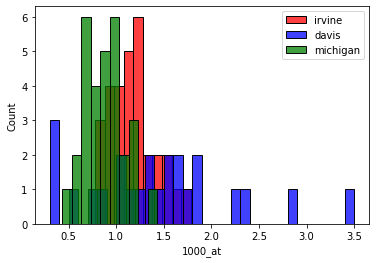

In [163]:
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Irvine'][genes_hum_index[0]], binwidth = 0.1, color = 'red')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Davis'][genes_hum_index[0]], binwidth = 0.1, color = 'blue')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Michigan'][genes_hum_index[0]], binwidth = 0.1, color = 'green')
plt.legend(labels = ['irvine', 'davis', 'michigan'])

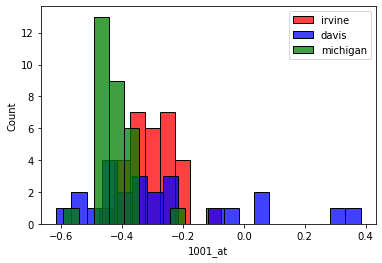

In [164]:
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Irvine'][genes_hum_index[1]], binwidth = 0.05, color = 'red')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Davis'][genes_hum_index[1]], binwidth = 0.05, color = 'blue')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Michigan'][genes_hum_index[1]], binwidth = 0.05, color = 'green')
plt.legend(labels = ['irvine', 'davis', 'michigan'])

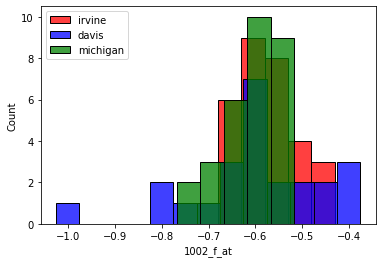

In [165]:
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Irvine'][genes_hum_index[2]], binwidth = 0.05, color = 'red')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Davis'][genes_hum_index[2]], binwidth = 0.05, color = 'blue')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Michigan'][genes_hum_index[2]], binwidth = 0.05, color = 'green')
plt.legend(labels = ['irvine', 'davis', 'michigan'])

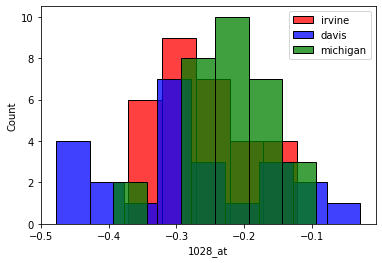

In [166]:
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Irvine'][genes_hum_index[30]], binwidth = 0.05, color = 'red')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Davis'][genes_hum_index[30]], binwidth = 0.05, color = 'blue')
sns.histplot(express_norm_samp[express_norm_samp['lab'] == 'Michigan'][genes_hum_index[30]], binwidth = 0.05, color = 'green')
plt.legend(labels = ['irvine', 'davis', 'michigan'])

In [167]:
genes_hum_index[30]

'1028_at'

In [ ]:
expression.shape

(84, 12600)

In [ ]:
expression.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at
01_a_D_f_2.CEL,9.521934,7.453767,7.045636,7.743690,7.728274,8.081243,6.927978,9.294152,8.888816,8.290944,...,7.065597,6.803698,6.631766,6.981474,7.003319,6.999630,7.005495,6.864895,7.030665,14.394582
01_a_I_f_2.CEL,10.930684,9.455482,9.233291,9.777128,9.612399,9.845444,9.149639,10.580062,11.505571,9.846817,...,9.366604,9.067484,8.945584,9.118070,9.137492,9.067202,9.129742,9.256544,9.171725,15.494106
01_a_M_f_1.CEL,6.852731,5.298974,5.033266,6.040661,5.890083,5.810144,5.098923,6.240855,7.280948,6.124910,...,5.374457,5.165619,5.032617,5.382904,5.509690,5.113946,5.273243,5.321357,5.321636,12.856782
01_c_D_f_1.CEL,7.285181,6.258114,6.119443,6.631768,6.744592,6.589478,6.156638,7.417750,8.663882,8.203275,...,6.332162,6.278864,6.108778,6.341791,6.339638,6.167335,6.170734,6.734936,6.275118,13.683484
01_c_I_f_2.CEL,11.224543,9.800931,9.407753,10.113212,9.871853,10.495533,9.449701,11.084619,11.969619,10.479006,...,9.443910,9.242560,9.272848,9.435175,9.448927,9.395768,9.306998,9.863770,9.404475,15.494106


In [ ]:
samples.head()

,patient,sex,region,lab,chip.version
rownames,,,,,
01_a_D_f_2.CEL,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,patient_01,female,cerebellum,Irvine,v2


In [ ]:
genes

,sym,chrom
rownames,,
1000_at,MAPK3,16
1001_at,TIE1,1
1002_f_at,CYP2C19,10
1003_s_at,CXCR5,11
1004_at,CXCR5,11
...,...,...
AFFX-YEL002c/WBP1_at,NaN,NaN
AFFX-YEL018w/_at,NaN,NaN
AFFX-YEL021w/URA3_at,NaN,NaN


Comparing results from Davis, Irvine and Michigan

In [ ]:
davis = expression[expression.index.str.contains('_D_')]
irvine = expression[expression.index.str.contains('_I_')]
michigan = expression[expression.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

In [ ]:
def histo(var_name):
  sns.histplot(x = irvine[var_name], binwidth = 0.2, color = 'red')
  sns.histplot(x = davis[var_name], binwidth = 0.2, color = 'blue')
  sns.histplot(x = michigan[var_name], binwidth = 0.2, color = 'green')
  plt.legend(labels = ['irvine', 'davis', 'michigan'])

In [ ]:
def linepl(var_name):
  temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
  plt.plot(np.arange(1,31), temp[var_name + '_x'], label = 'irvine')
  plt.plot(np.arange(1,31), temp[var_name + '_y'], label = 'davis')
  plt.plot(np.arange(1,31), temp[var_name], label = 'michigan')
  plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")

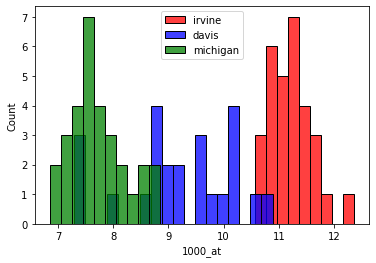

In [ ]:
histo('1000_at')

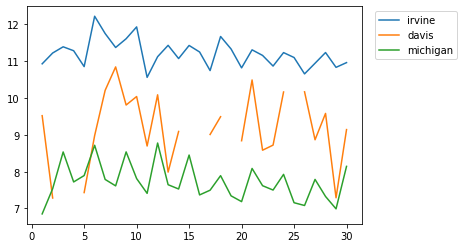

In [ ]:
linepl('1000_at')

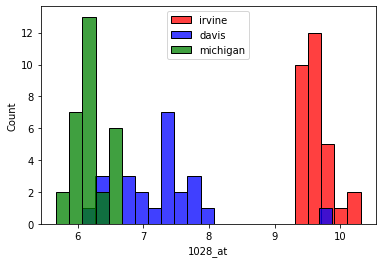

In [ ]:
histo(expression.columns[30])

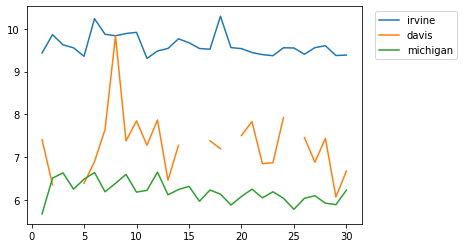

In [ ]:
linepl(expression.columns[30])

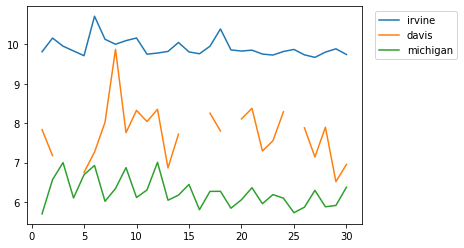

In [ ]:
linepl(expression.columns[3698])

In [ ]:
expression

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at
01_a_D_f_2.CEL,9.521934,7.453767,7.045636,7.743690,7.728274,8.081243,6.927978,9.294152,8.888816,8.290944,...,7.065597,6.803698,6.631766,6.981474,7.003319,6.999630,7.005495,6.864895,7.030665,14.394582
01_a_I_f_2.CEL,10.930684,9.455482,9.233291,9.777128,9.612399,9.845444,9.149639,10.580062,11.505571,9.846817,...,9.366604,9.067484,8.945584,9.118070,9.137492,9.067202,9.129742,9.256544,9.171725,15.494106
01_a_M_f_1.CEL,6.852731,5.298974,5.033266,6.040661,5.890083,5.810144,5.098923,6.240855,7.280948,6.124910,...,5.374457,5.165619,5.032617,5.382904,5.509690,5.113946,5.273243,5.321357,5.321636,12.856782
01_c_D_f_1.CEL,7.285181,6.258114,6.119443,6.631768,6.744592,6.589478,6.156638,7.417750,8.663882,8.203275,...,6.332162,6.278864,6.108778,6.341791,6.339638,6.167335,6.170734,6.734936,6.275118,13.683484
01_c_I_f_2.CEL,11.224543,9.800931,9.407753,10.113212,9.871853,10.495533,9.449701,11.084619,11.969619,10.479006,...,9.443910,9.242560,9.272848,9.435175,9.448927,9.395768,9.306998,9.863770,9.404475,15.494106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_c_I_f_2.CEL,10.834992,9.375171,9.100567,9.766162,9.441591,10.245868,9.065520,10.590598,11.039345,10.225186,...,9.197899,8.932622,8.950766,9.120934,9.018108,9.007320,9.010432,9.093493,8.986246,15.493637
10_c_M_f_1.CEL,6.990507,5.671513,5.398236,6.182388,6.088754,6.074909,5.479757,6.328909,7.675669,6.726671,...,5.563038,5.453313,5.228861,5.498717,5.515519,5.379649,5.460068,5.455070,5.488273,12.665336
10_d_D_f_2.CEL,9.143998,6.862450,6.357731,7.134995,7.046711,7.730850,6.183967,9.414389,9.065153,8.863422,...,6.258799,6.027364,5.907490,6.171226,6.130500,6.080228,5.966166,6.135691,6.023620,14.244014
10_d_I_f_2.CEL,10.963519,9.338467,9.047548,9.696127,9.541697,9.792356,9.073002,10.775091,11.373533,10.350302,...,9.126488,8.891157,8.935299,9.080840,9.166819,9.042159,9.048415,9.007950,9.115568,15.493855


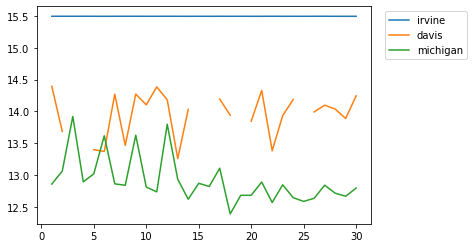

In [ ]:
linepl(expression.columns[-1])

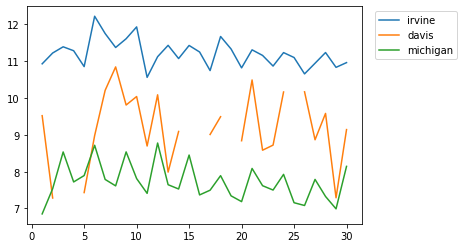

In [ ]:
linepl(expression.columns[0])

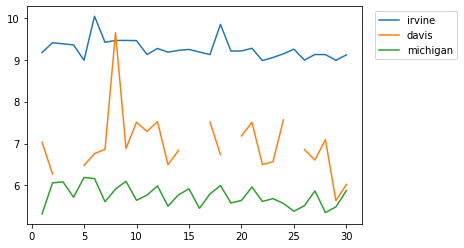

In [ ]:
linepl(expression.columns[-2])

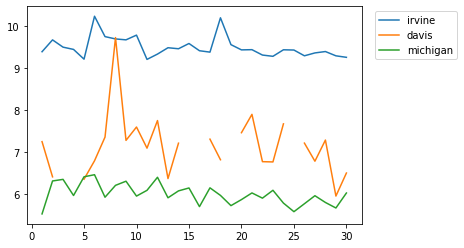

In [ ]:
linepl(expression.columns[129])

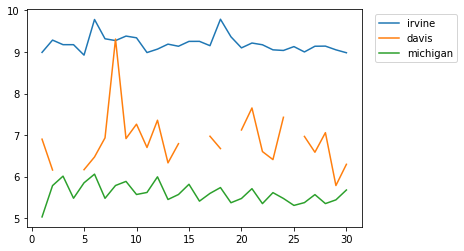

In [ ]:
linepl(expression.columns[534])

In [ ]:
np.corrcoef(expression[expression.columns[534]], expression[expression.columns[30]])

array([[1.        , 0.99641327],
       [0.99641327, 1.        ]])

In [ ]:
np.corrcoef(expression[expression.columns[0]], expression[expression.columns[-2]])

array([[1.        , 0.95821417],
       [0.95821417, 1.        ]])

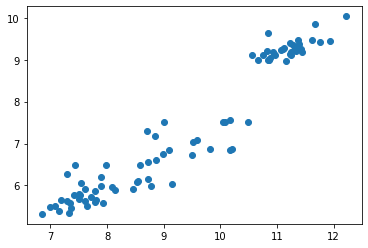

In [ ]:
plt.scatter(expression[expression.columns[0]],  expression[expression.columns[-2]])

In [ ]:
expression.columns[-2]

'AFFX-YEL024w/RIP1_at'

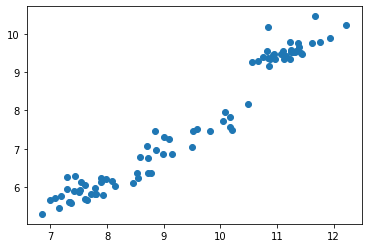

In [ ]:
plt.scatter(expression[expression.columns[0]],  expression[expression.columns[1]])

In [ ]:
joined = pd.merge(expression, samples, how = 'left', left_index = True, right_index = True)
joined = joined[joined['lab'] == 'Michigan']
joined = joined[['1000_at', 'sex', 'region']]
joined = pd.concat([joined[['1000_at']], pd.get_dummies(joined['sex']), pd.get_dummies(joined['region'])], axis=1)
joined = joined.drop(['female', 'A.C. cortex'], axis = 1)
joined.columns = ['y', 'male', 'dlpf_cortex', 'cerebellum']

# smf.logit(formula='y ~ x1 + x2 + x1:x2', data=df).fit()
# smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)

In [ ]:
joined.columns

Index(['y', 'male', 'dlpf_cortex', 'cerebellum'], dtype='object')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model = smf.ols(formula = "y ~ male + dlpf_cortex + cerebellum + male * dlpf_cortex + male * cerebellum", data = joined)
results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     9.014
Date:                Sun, 25 Sep 2022   Prob (F-statistic):           6.29e-05
Time:                        21:30:42   Log-Likelihood:                -5.7666
No. Observations:                  30   AIC:                             23.53
Df Residuals:                      24   BIC:                             31.94
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.3864      0.147     50.376      0.000       7.084       7.689
male                 0.1549      0.207      0.747      0.462      -0.273       0.583
dlpf_cortex          0.8602      0.207      4.148      0.000       0.432       1.288
cerebellum          -0.0200      0.207     -0.097      0.924      -0.448       0.408
male:dlpf_cortex    -0.0754      0.293     -0.257      0.799      -0.681       0.530
male:cerebellum     -0.0383      0.293     -0.131      0.897      -0.644       0.567
==============================================================================
Omnibus:                        3.675   Durbin-Watson:                   0.938
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                1.794
Skew:                          -0.277   Prob(JB):                        0.408
Kurtosis:                       1.938   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# estimate ATE for ac cortex
temp = joined[(joined['dlpf_cortex'] == 0) & (joined['cerebellum'] == 0)]
print(temp[temp['male'] == 1]['y'].mean() - temp[temp['male'] == 0]['y'].mean())

0.15489461257420611


In [ ]:
# estimate ATE for dlpf cortex
temp = joined[(joined['dlpf_cortex'] == 1) & (joined['cerebellum'] == 0)]
print(temp[temp['male'] == 1]['y'].mean() - temp[temp['male'] == 0]['y'].mean())

0.07950536451884815


In [ ]:
# estimate ATE for cerebellum
temp = joined[(joined['dlpf_cortex'] == 0) & (joined['cerebellum'] == 1)]
print(temp[temp['male'] == 1]['y'].mean() - temp[temp['male'] == 0]['y'].mean())

0.11658115236642885
